# Εργαστηριακή Άσκηση 4: Nyquist signaling and L-ASK
After studying Chapter 4 of the notes and, in particular, Example 4.2, write and run
code for the following:

## Part 1: Useful Code

```{admonition} Live Code
Press the following button to make python code interactive. It will connect you to a kernel once it says "ready" (might take a bit, especially the first time it runs).
```

<div style="text-align: center;">
  <button title="Launch thebe" class="thebelab-button thebe-launch-button" onclick="initThebe()">Python Interactive Code</button>
</div>

#### Importing packages we will need later in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
import scipy.special
from math import log

`````` {dropdown} Useful functions
````` {tab} Python
````python

# The function grayCode accepts a number n and returns an array g containing
# the Gray coding for numbers with n bits.
# This is done by recursively calling the function gray_code_recurse
def grayCode(n):
    def gray_code_recurse (g,n):
        k=len(g)
        if n<=0:
            return
        else:
            for i in range (k-1,-1,-1):
                char='1'+g[i]
                g.append(char)
            for i in range (k-1,-1,-1):
                g[i]='0'+g[i]

            gray_code_recurse (g,n-1)

    g=['0','1']
    gray_code_recurse(g,n-1)
    return g


# The function naturalBinaryCoding accepts a number n and returns an array
# with binary numbers with n bits (or equivalently up to the number 2**n, which results
# by left shifting 1 by n bits)
def naturalBinaryCoding(n):
    binary_levels = []
    for i in range(1 << n):
        binary_levels.append('{:0{}b}'.format(i, n))
    return binary_levels


# The function generateRandomBits generates n_bits random binary digits
def generateRandomBits(n_bits):
    bitstream = []
    for i in range(n_bits):
        random_bit = random.randint(0, 1)
        bitstream.append(random_bit)
    return bitstream


# The function createLevels divides the range [-A, A] into L-1 equal intervals,
# so that it always contains the endpoints of the range
def createLevels(A, L):
    y = []
    step = (A - (-A)) / (L - 1)
    for i in range(L):
        y.append(-A + i * step)
    return y


# The function createSymbols takes an array with bits as an argument and
# groups neighboring digits into symbols with length k
def createSymbols(k, bitstream):
    n_bits = len(bitstream)
    symbols = []
    for i in range(0, n_bits - k + 1, k):
        symbol = ""
        for j in range(k):
            symbol += str(bitstream[i+j])
        symbols.append(symbol)
    return symbols


# The function rootRaisedCosine creates a root raised cosine pulse
# with a roll-off coefficient and order determined by the sampling rate (nsample)
# and the delay it will introduce (delay)
def rootRaisedCosine(nsamp, roll_off, delay):
    F0 = 0.5 / nsamp
    Fd = 1
    Fs = Fd * nsamp
    Td = 1 / Fd
    Ts = 1 / Fs
    F1 = F0 * (1 - roll_off)
    F2 = F0 * (1 + roll_off)
    filter_order = 2 * nsamp * delay

    t = np.arange(0, filter_order, Td)
    h = []
    for i in range(len(t)):
        t_shifted = t[i] - filter_order / 2
        if t_shifted == 0:
            h.append(np.sqrt(2 * F0) *(1 + roll_off * ((4 / np.pi) - 1)))
        elif t_shifted == 1 / 8 / roll_off / F0 or t_shifted == - 1 / 8 / roll_off / F0 :
            h.append((roll_off * np.sqrt(F0)) * ((1 + 2 / np.pi) * np.sin(np.pi / 4 / roll_off) + (1 - 2 / np.pi) * np.cos(np.pi / 4 / roll_off)))
        else:
            factor1 = np.sqrt(2 * F0) / (1 - 64 * roll_off* roll_off * F0 * F0 * t_shifted * t_shifted)
            factor2 = np.sin(2 * np.pi * F1 * t_shifted) / (2 * np.pi * F0 * t_shifted)
            factor3 = (4 * roll_off / np.pi) * np.cos(2 * np.pi * F2 * t_shifted) 
            h.append(factor1 * (factor2 + factor3))


    plt.plot(t,h)
    plt.grid()
    plt.title('Root raised cosine filter of order %d and roll-off factor %.1f' % (filter_order, roll_off))
    plt.show()
    
    return h


# The function upSample increases the number of samples of a signal signal by adding nsamp-1
# zeros after each sample of the signal
def upSample(signal, nsamp):
    upSampled = []
    for i in range(len(signal) * nsamp):
        if i % nsamp == 0:
            upSampled.append(signal[i // nsamp])
        else:
            upSampled.append(0)
    return upSampled


# The function downSample reduces the sampling frequency of a signal signal by a factor of nsamp
# by keeping only the samples that are multiples of nsamp (0, nsamp, 2*nsamp, ...)
def downSample(signal, nsamp):
    downSampled = []
    for i in range(0, len(signal), nsamp):
        downSampled.append(signal[i])
        
    return downSampled


# Adds white Gaussian noise with mean value μ (mu) and variance σ^2 (sigma)
def generateAWGN(signal, mu, sigma):
    noise = sigma * np.random.randn(len(signal)) + mu
    return noise
    
````
`````
``````

### Signal generation with Nyquist filters – Time and frequency plots
Generate a random binary sequence of 10000 bits and then a corresponding 8-ASK
baseband signal, with the following characteristics:

- Gray coding
- Nyquist root raised cosine signaling, with roll-off =0.40
- Over-sampling with nsamp=20 samples per base period T
- Transmitter filter class: 200 (10 periods, group_delay=5T)

``` {hint} 
To Gray encode a binary vector, x, into L-ASK symbols, use the following code segment,
where step is the distance (or increment) between adjacent L-ASK points.
Briefly explain its function and, in particular, the role of the mapping vector (see also Hint in the
next question).
```

```` {tab} Matlab
```matlab

L=…; step=…; % ο αριθμός των πλατών και το βήμα μεταξύ τους
k=log(L);
mapping=[step/2; -step/2];
if(k>1)
	for j=2:k
	mapping=[mapping+2^(j-1)*step/2; ...
	-mapping-2^(j-1)*step/2];
	end
end;
xsym=bi2de(reshape(x,k,length(x)/k).','left-msb');
y=[];
for i=1:length(xsym)
	y=[y mapping(xsym(i)+1)];
end

```
````

1. Calculate the signal at the output of the matched filter at the receiver.
Show part of this signal (with the plot command) of 10T duration.
2. Superimpose (with the stem command) on this part the corresponding
samples of the input signal in the basic period grid T (before over-sampling)
3. Plot (using the pwelch command) the spectrum of the signal at the
receiver and explain its shape and amplitude.

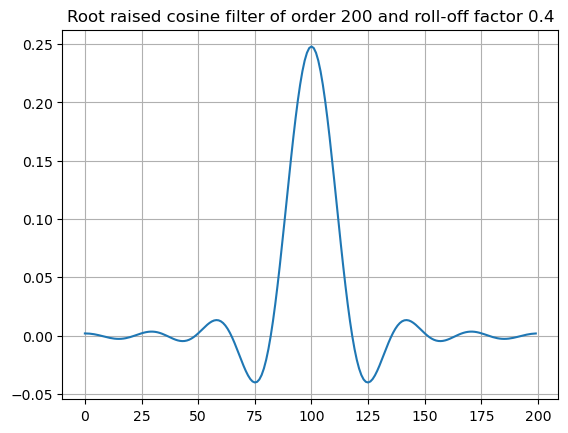

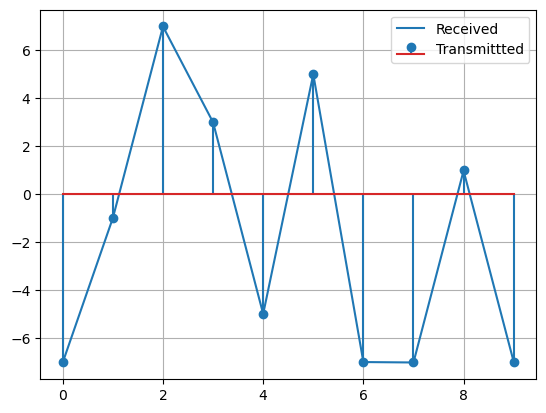

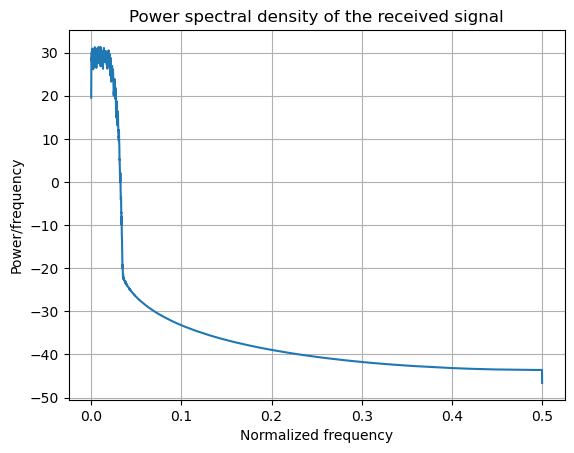

In [18]:
# The function grayCode accepts a number n and returns an array g containing
# the Gray coding for numbers with n bits.
# This is done by recursively calling the function gray_code_recurse
def grayCode(n):
    def gray_code_recurse (g,n):
        k=len(g)
        if n<=0:
            return
        else:
            for i in range (k-1,-1,-1):
                char='1'+g[i]
                g.append(char)
            for i in range (k-1,-1,-1):
                g[i]='0'+g[i]

            gray_code_recurse (g,n-1)

    g=['0','1']
    gray_code_recurse(g,n-1)
    return g


# The function naturalBinaryCoding accepts a number n and returns an array
# with binary numbers with n bits (or equivalently up to the number 2**n, which results
# by left shifting 1 by n bits)
def naturalBinaryCoding(n):
    binary_levels = []
    for i in range(1 << n):
        binary_levels.append('{:0{}b}'.format(i, n))
    return binary_levels


# The function generateRandomBits generates n_bits random binary digits
def generateRandomBits(n_bits):
    bitstream = []
    for i in range(n_bits):
        random_bit = random.randint(0, 1)
        bitstream.append(random_bit)
    return bitstream


# The function createLevels divides the range [-A, A] into L-1 equal intervals,
# so that it always contains the endpoints of the range
def createLevels(A, L):
    y = []
    step = (A - (-A)) / (L - 1)
    for i in range(L):
        y.append(-A + i * step)
    return y


# The function createSymbols takes an array with bits as an argument and
# groups neighboring digits into symbols with length k
def createSymbols(k, bitstream):
    n_bits = len(bitstream)
    symbols = []
    for i in range(0, n_bits - k + 1, k):
        symbol = ""
        for j in range(k):
            symbol += str(bitstream[i+j])
        symbols.append(symbol)
    return symbols


# The function rootRaisedCosine creates a root raised cosine pulse
# with a roll-off coefficient and order determined by the sampling rate (nsample)
# and the delay it will introduce (delay)
def rootRaisedCosine(nsamp, roll_off, delay):
    F0 = 0.5 / nsamp
    Fd = 1
    Fs = Fd * nsamp
    Td = 1 / Fd
    Ts = 1 / Fs
    F1 = F0 * (1 - roll_off)
    F2 = F0 * (1 + roll_off)
    filter_order = 2 * nsamp * delay

    t = np.arange(0, filter_order, Td)
    h = []
    for i in range(len(t)):
        t_shifted = t[i] - filter_order / 2
        if t_shifted == 0:
            h.append(np.sqrt(2 * F0) *(1 + roll_off * ((4 / np.pi) - 1)))
        elif t_shifted == 1 / 8 / roll_off / F0 or t_shifted == - 1 / 8 / roll_off / F0 :
            h.append((roll_off * np.sqrt(F0)) * ((1 + 2 / np.pi) * np.sin(np.pi / 4 / roll_off) + (1 - 2 / np.pi) * np.cos(np.pi / 4 / roll_off)))
        else:
            factor1 = np.sqrt(2 * F0) / (1 - 64 * roll_off* roll_off * F0 * F0 * t_shifted * t_shifted)
            factor2 = np.sin(2 * np.pi * F1 * t_shifted) / (2 * np.pi * F0 * t_shifted)
            factor3 = (4 * roll_off / np.pi) * np.cos(2 * np.pi * F2 * t_shifted) 
            h.append(factor1 * (factor2 + factor3))


    plt.plot(t,h)
    plt.grid()
    plt.title('Root raised cosine filter of order %d and roll-off factor %.1f' % (filter_order, roll_off))
    plt.show()
    
    return h


# The function upSample increases the number of samples of a signal signal by adding nsamp-1
# zeros after each sample of the signal
def upSample(signal, nsamp):
    upSampled = []
    for i in range(len(signal) * nsamp):
        if i % nsamp == 0:
            upSampled.append(signal[i // nsamp])
        else:
            upSampled.append(0)
    return upSampled


# The function downSample reduces the sampling frequency of a signal signal by a factor of nsamp
# by keeping only the samples that are multiples of nsamp (0, nsamp, 2*nsamp, ...)
def downSample(signal, nsamp):
    downSampled = []
    for i in range(0, len(signal), nsamp):
        downSampled.append(signal[i])
        
    return downSampled


# Adds white Gaussian noise with mean value μ (mu) and variance σ^2 (sigma)
def generateAWGN(signal, mu, sigma):
    noise = sigma * np.random.randn(len(signal)) + mu
    return noise


n_bits = 10000
bitstream = generateRandomBits(n_bits) # Generating random bits

L = 8 # Number of ASK levels
A = L-1 
k = int(log(L,2)) # Number of digits in each symbol
n_symb = n_bits / k # Number of symbols resulting from the random bits

y_levels = createLevels(A, L) # [-15, -13, -11 ... 11 13 15]

symbols = createSymbols(k, bitstream) # Grouping into symbols

gray_encoding = grayCode(k) # Applying Gray encoding

# x_gray contains the voltage level corresponding to each of the symbols
x_gray = [] 
for i in range(len(symbols)):
    x_gray.append(y_levels[gray_encoding.index(symbols[i])])


nsamp = 20
roll_off = 0.40
delay = 5
filter_order = 2 * nsamp * delay

# Creating the raised cosine filter
# Upsampling and convolution with the random integers 
filt = rootRaisedCosine(nsamp, roll_off, delay)
y = upSample(x_gray, nsamp)
y_transmitted = scipy.signal.convolve(y, filt)

# At the receiver, the signal is filtered again by the root raised cosine filter
y_received = scipy.signal.convolve(y_transmitted, filt)
y_final = downSample(y_received, nsamp)

# Trimming the tails resulted from the convolutions
y_final = y_final[2 * delay: len(y_final) - 2 *delay]

# Displaying on a common chart the received signal after downsampling 
# and the original random integers
t = np.arange(0, len(y[:10]))
plt.figure()
plt.plot(t, y_final[:10])
plt.stem(t, x_gray[:10])
plt.legend(['Received','Transmitted'])
plt.grid()
plt.show()


# Calculating the power spectral density of the received signal
f, Pxx_den = scipy.signal.welch(y_received, window='hamming', nperseg=8192)
Pxx_den = 10 * np.log10(Pxx_den)
fig = plt.figure()
plt.plot(f, Pxx_den)
plt.grid()
plt.title('Power spectral density of the received signal')
plt.xlabel('Normalized frequency')
plt.ylabel('Power/frequency')
plt.show()

### 2. Performance calculation: BER vs Eb/No. 
  Study of the effect of parameters: Nyquist filter order and roll-off

Για την 8-ASK, να ληφθεί η καμπύλη BER-Eb/No θεωρητικά και με εξομοίωση
- με roll-off=0.1 και τάξη φίλτρου
  - 64 (2 περιόδων, group_delay =T)
  - 128 (4 περιόδων, group_delay =2T)
  - 320 (10 περιόδων, group_delay =5T).
- με roll-off=0.2 και τάξη φίλτρου όπως στις περιπτώσεις a,b,c παραπάνω.
- με roll-off=0.4 και τάξη φίλτρου όπως στις περιπτώσεις a,b,c παραπάνω.


Υπόδειξη: Για την εκτίμηση Μέγιστης Πιθανοφάνειας, να συγκριθεί κάθε λαμβανόμενο
σύμβολο (δείγμα στην έξοδο του προσαρμοσμένου φίλτρου) με τα στοιχεία του διανύσματος
mapping. Η θέση του πλησιέστερου στοιχείου στο διάνυσμα θα δώσει και την αντίστοιχη
κωδικολέξη. Το παρακάτω τμήμα κώδικα είναι μια υλοποίηση αυτού του φωρατή.


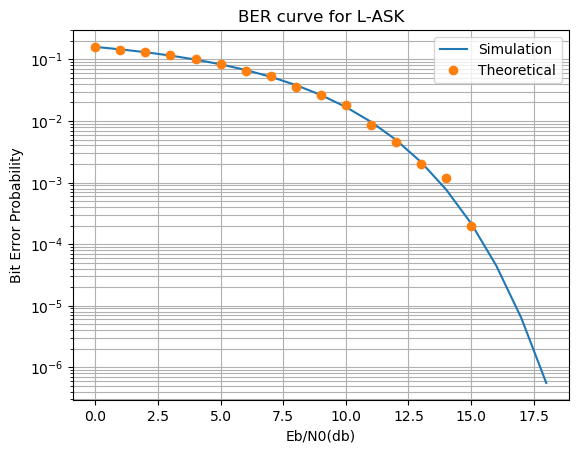

In [14]:
# Υπολογισμός της πιθανότητας εσφαλμένου ψηφίου θεωρητικά και μέσω προσομοίωσης

berTheoretical = []
berSimulation = []
EbN0_max = 20

for EbN0_db in range(1,EbN0_max):
    
    # SNR και Eb/N0 σε γραμμική κλίμακα και dB
    EbN0 = 10 ** (EbN0_db * 0.1)
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)

    # Υπολογισμός της ισχύος του μεταδιδομένου σήματος και της ισχύος θορύβου 
    # ώστε να έχουμε το επιθυμητό SNR
    P = sum(y_transmitted * y_transmitted) / len(y_transmitted)
    P_db = 10 * np.log10(P)
    Pn_db = P_db - SNR_db
    Pn = 10 ** (Pn_db * 0.1)

    # Προσθήκη θορύβου AWG
    mu = 0
    sigma = np.sqrt(Pn)
    noise = generateAWGN(y_transmitted, mu, sigma)
    y_noisy = y_transmitted + noise

    # Στον δέκτη γίνεται φιλτράρισμα και υποδειγμάτιση
    z_received = scipy.signal.convolve(y_noisy, filt)
    z_final = downSample(z_received, nsamp)
    
    # Περικοπή των ουρών λόγω των συνελίξεων
    z_final = z_final[2 * delay : len(z_final) - 2 * delay]

    # Απόφαση για το επίπεδο στο οποίο αντιστοιχεί το σύμβολο που ελήφθη
    for i in range(len(z_final)):
        # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        differences = np.abs(y_levels - z_final[i]) 
        m = min(differences) # Εύρεση ελάχιστης απόστασης
        [index], = np.where(differences == m)
        z_final[i] = y_levels[index]
    
    # Λόγω της κωδικοποίησης Gray θεωρούμε ότι σε κάθε λάθος έχουμε ένα εσφαλμένο bit
    error = 0
    for i in range(len(z_final)):
        if x_gray[i] != z_final[i]:
            error += 1
    
    # Πιθανότητα λάθους = αριθμός λαθών / αριθμών ψηφίων
    berSimulation.append(error/n_bits)
    # Θεωρητική τιμή της πιθανότητας εσφαλμένου ψηφίου
    Pe = (L - 1) / L * scipy.special.erfc(np.sqrt(3 * k / (L * L - 1) * EbN0))
    berTheoretical.append(Pe / k)

plt.figure()
plt.semilogy(berTheoretical)
plt.semilogy(berSimulation,'o')
plt.legend(['Simulation', 'Theoretical'])
plt.xlabel('Eb/N0(db)')
plt.ylabel('Bit Error Probability')
plt.title('BER curve for L-ASK')
plt.grid(which='both')
plt.show()

### 3. Επίδραση του τρόπου κωδικοποίησης: Gray ή άλλη

Να παραχθούν καμπύλες BER-Eb/No για τις 16-ASK και 8-ASK με κωδικοποίηση
άλλη (όχι Gray), π.χ. με $mapping=-(L-1):step:(L-1)$, και να συγκριθούν με τις
θεωρητικές. Τι παρατηρείτε;

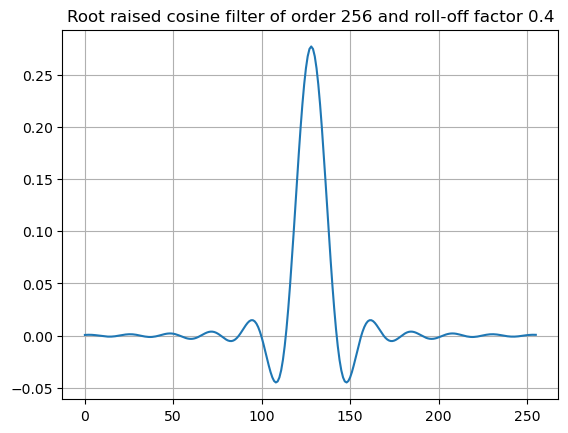

In [15]:
# Επαναλάμβάνουμε την παραπάνω διαδικασία, αλλά θεωρούμε κωδικοποίηση με δυαδικούς αριθμούς αντί για Gray

n_bits = 80000
bitstream = generateRandomBits(n_bits)

L = 16 # Αριθμός επιπέδων της ASK
A = L-1 
k = int(log(L,2)) # Αριθμός ψηφίων σε κάθε σύμβολο
n_symb = n_bits / k # Αριθμός συμβόλων που προκύπτουν από τα τυχαία bits

y_levels = createLevels(A, L) # [-15, -13, -11 ... 11 13 15]
symbols = createSymbols(k, bitstream) # Ομαδοποίηση σε σύμβολα
natural_encoding = naturalBinaryCoding(k) # Κωδικοποίηση με δυαδικούς αριθμούς

# Η x_natural περιέχει το επίπεδο τάσης στο οποίο αντιστοιχεί καθένα από τα σύμβολα
x_natural = []
for i in range(len(symbols)):
    x_natural.append(y_levels[natural_encoding.index(symbols[i])])
    
nsamp = 16
roll_off = 0.4
delay = 8
filter_order = 2 * nsamp * delay

# Δημιουργία του φίλτρου ανυψωμένου συνημιτόνου
# Υπερδειγμάτιση και συνέλιξη με τους τυχαίους ακεραίους 
filt = rootRaisedCosine(nsamp, roll_off, delay)
y = upSample(x_natural, nsamp)
y_transmitted = scipy.signal.convolve(y, filt)

# Στον δέκτη το σήμα φιλτράρεται πάλι από το φίλτρο root raised cosine
y_received = scipy.signal.convolve(y_transmitted, filt)
y_final = downSample(y_received, nsamp)
y_final = y_final[2 * delay: len(y_final) - 2 *delay]

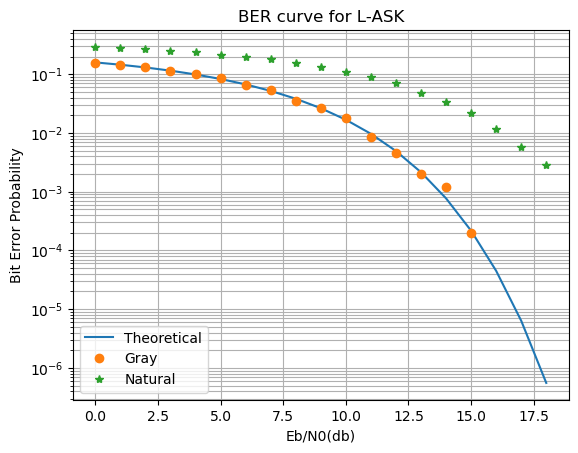

In [16]:
# Υπολογισμός της πιθανότητας εσφαλμένου ψηφίου θεωρητικά και μέσω προσομοίωσης
berSimulation_natural = []
EbN0_max = 20

for EbN0_db in range(1,EbN0_max):
    
    EbN0 = 10 ** (EbN0_db * 0.1)
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)

    # Υπολογισμός της ισχύος του μεταδιδομένου σήματος και της ισχύος θορύβου ώστε να έχουμε το επιθυμητό SNR
    P = sum(y_transmitted * y_transmitted) / len(y_transmitted)
    P_db = 10 * np.log10(P)
    Pn_db = P_db - SNR_db
    Pn = 10 ** (Pn_db * 0.1)

    mu = 0
    sigma = np.sqrt(Pn)
    noise = generateAWGN(y_transmitted, mu, sigma)
    y_noisy = y_transmitted + noise

    # Στον δέκτη γίνεται φιλτράρισμα και υποδειγμάτιση
    z_received = scipy.signal.convolve(y_noisy, filt)
    z_final = downSample(z_received, nsamp)
    z_final = z_final[2 * delay : len(z_final) - 2 * delay]

    # Απόφαση για το επίπεδο στο οποίο αντιστοιχεί το σύμβολο που ελήφθη
    for i in range(len(z_final)):
        differences = np.abs(y_levels - z_final[i])
        m = min(differences)
        [index], = np.where(differences == m)
        z_final[i] = y_levels[index]
    
    # Ο final_symbols περιέχει τα bits που αποφασίστηκε ότι ελήφθησαν
    final_symbols = []
    for i in range(len(z_final)):
        # Αντιστοίχηση κάθε επιπέδου που αποφασίστηκε παραπάνω στην δυαδική κωδικοποίηση του
        index = y_levels.index(z_final[i])
        final_symbols.append(natural_encoding[index])

    # Για κάθε εσφαλμένο σύμβολο πρέπει να ελέγξουμε πόσα ψηφία ήταν λάθος, καθώς η κωδικοποίηση 
    # των γειτονικών επιπέδων δεν απέχει πλέον κατά μόνο ένα ψηφίο 
    error = 0
    for i in range(len(z_final)):
        # Εάν ένα σύμβολο είναι λάθος, έλεγξε πόσα ψηφία ελήφθηφαν εσφαλμένα
        if x_natural[i] != z_final[i]:
            for j in range(len(symbols[i])):
                if symbols[i][j] != final_symbols[i][j]:
                    error += 1
        
    berSimulation_natural.append(error/n_bits)

plt.figure()
plt.semilogy(berTheoretical)
plt.semilogy(berSimulation,'o')
plt.semilogy(berSimulation_natural,'*')
plt.legend(['Theoretical', 'Gray', 'Natural'])
plt.xlabel('Eb/N0(db)')
plt.ylabel('Bit Error Probability')
plt.title('BER curve for L-ASK')
plt.grid(which='both')
plt.show()

### 4. Υπολογισμός παραμέτρων συστήματος
 Το απαιτούμενο εύρος βασικής ζώνης με σηματοδοσία Nyquist, ισούται με
$$ W = \frac{1}{2T}(1+\alpha) $$ 

όπου α ο συντελεστής εξάπλωσης (roll-off factor) του φίλτρου Nyquist και $ \frac{1}{T} $
ρυθμός μετάδοσης συμβόλων (ονομαζόμενος και Baud Rate). Εξ άλλου, ο ρυθμός μετάδοσης, $R$
(bits/s), συνδέεται με το $ \frac{1}{T} $ και το μέγεθος του σηματικού αστερισμού, $L$, με τη σχέση
$$ \frac{R}{\log_2 L} = \frac{l}{T} $$

αποτελεί, συνεπώς, τη συνδετική παράμετρο μεταξύ των $W$ και $R$.